## Bandwidth Expansion Using Perceptually-Motivated Loss

This notebook guides you through training and testing an FFTNet network for bandwidth expansion. The training objective is a waveform-based L1 loss + spectrogram-based L1 loss. Be sure to adjust the following parameters according to your data:
* `wb_sr`: wideband sampling rate (e.g., 44100)
* `data_dir_train`: directory containing subdirectories 'nb/' and 'wb/' each with the audio files you would like to train with
* `data_dir_test`: directory containing subdirectories 'nb/' and 'wb/' each with the audio files you would like to test on

You can optionally adjust training hyperparameters, such as `C` (TensorFlow placeholder weight on perceptual loss) and `n_channels`.

In [1]:
import tensorflow as tf
import numpy as np
import platform
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import librosa
import IPython.display as ipd
import os
import sys
from scipy import signal

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# ADJUST THESE ACCORDING TO YOUR DATA
wb_sr = 44100
data_dir_train = 'data/train/'
data_dir_test = 'data/test/'

### Data preparation
The data is prepared using MATLAB. The final bundled .mat file is loaded and stored in memory using the following class.

In [3]:
class UpsampleData:
    def __init__(self, data_dir_x, data_dir_y, wb_sr=wb_sr, batch_size=4, batch_length=16000):
        self.data = {
            'xx': self._load_data(data_dir_x, wb_sr),
            'yy': self._load_data(data_dir_y, wb_sr)
        }
        
        self.batch_size = batch_size
        self.batch_length = batch_length
        self.cache_x = np.zeros([batch_size, batch_length], dtype=np.float32)
        self.cache_y = np.zeros([batch_size, batch_length], dtype=np.float32)
        self.train_portion = 0.9
        self.train_count = np.floor(self.train_portion * self.data['xx'].shape[0])
        self.data_count = self.data['xx'].shape[0]
        
    def _load_data(self, data_dir, sr):
        data_files = [os.path.join(data_dir, fn) for fn in os.listdir(data_dir)]
        data, _ = librosa.load(data_files[0], sr=sr)
        for fn in data_files[1:]:
            data_next, _ = librosa.load(fn, sr=sr)
            data = np.concatenate([data, data_next])
        data = np.expand_dims(data, axis=1)
        return data
    
    def get_batch(self):
        for j in range(0, self.batch_size):
            idx = np.random.randint(0, self.train_count-self.batch_length-10)
            self.cache_x[j] = self.data['xx'][idx:idx+self.batch_length, 0]
            self.cache_y[j] = self.data['yy'][idx:idx+self.batch_length, 0]
        return self.cache_x, self.cache_y
    
    def get_batch_all(self):
        for j in range(0, self.batch_size):
            idx = np.random.randint(0, self.train_count-self.batch_length)
            self.cache_x[j] = self.data['xx'][idx:idx+self.batch_length, 0]
            self.cache_y[j] = self.data['yy'][idx:idx+self.batch_length, 0]
        return self.cache_x, self.cache_y
    
    def get_batch_test(self):
        for j in range(0, self.batch_size):
            idx = np.random.randint(self.train_count, self.data_count-self.batch_length-10)
            self.cache_x[j] = self.data['xx'][idx:idx+self.batch_length, 0]
            self.cache_y[j] = self.data['yy'][idx:idx+self.batch_length, 0]
        return self.cache_x, self.cache_y
    
    def get_long_test_seq(self, test_len=44100*3):
        idx = np.random.randint(self.train_count, self.data_count-test_len-10)
        x = self.data['xx'][idx:idx+test_len, 0]
        y = self.data['yy'][idx:idx+test_len, 0]
        return np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)
    
    def get_test_seq_all(self):
        x = self.data['xx'][:, 0]
        y = self.data['yy'][:, 0]
        return np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)
    
    def get_all_test(self):
        x = self.data['xx'][int(self.train_count):int(self.train_count)+8*44100, 0]
        y = self.data['yy'][int(self.train_count):int(self.train_count)+8*44100, 0]
        return np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)

In [5]:
data = UpsampleData(
    data_dir_train + 'nb', data_dir_train + 'wb', wb_sr=wb_sr)
data_test = UpsampleData(
    data_dir_test + 'nb', data_dir_test + 'wb', wb_sr=wb_sr)
data.get_batch()[0].shape

(4, 16000)

### Ops

In [6]:
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir))
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir))

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None

### Network definition
3-way split summation FFTNet + spectrogram loss

In [7]:
def create_conv_variable(name, shape, dtype=tf.float32):
    initializer = tf.contrib.layers.xavier_initializer_conv2d(dtype=dtype)
    variable = tf.Variable(initializer(shape=shape), name=name, dtype=dtype)
    return variable

def create_bias_variable(name, shape, dtype=tf.float32):
    initializer = tf.constant_initializer(value=0.0, dtype=dtype)
    return tf.Variable(initializer(shape=shape), name, dtype=dtype)

def conv_1x1(outputs, num_in, num_out, dropout=0.0, name='x1', dtype=tf.float32):
    weights = create_conv_variable('conv1d_weights_' + name, [1, num_in, num_out], dtype=dtype)
    biases = create_bias_variable('conv1d_bias_' + name, [num_out], dtype=dtype)
    outputs = tf.nn.conv1d(outputs, weights, stride=1, padding='SAME', name='dense')
    if dropout > 0.001:
        outputs = tf.nn.dropout(outputs, 1-dropout)
    return outputs + biases

def dilated_conv3(inputs, dilation, n_channels):
    seq_len = tf.shape(inputs)[1]
    shift_left = tf.pad(inputs, [[0, 0], [dilation, 0], [0, 0]])
    shift_left = tf.slice(shift_left, [0, 0, 0], [-1, seq_len, -1])
    shift_right = tf.pad(inputs, [[0, 0], [0, dilation], [0, 0]])
    shift_right = tf.slice(shift_right, [0, dilation, 0], [-1, seq_len, -1])
    shift_left = conv_1x1(shift_left, n_channels, n_channels)
    shift_right = conv_1x1(shift_right, n_channels, n_channels)
    inputs = conv_1x1(inputs, n_channels, n_channels)
    return inputs + shift_left + shift_right

def get_spec(inputs, sample_rate=44100, frame_length=1024):
    spec = tf.contrib.signal.stft(inputs, frame_length=frame_length, frame_step=256, fft_length=2048)
    mag_spec = tf.abs(spec)
    n_bins = 1025
    lower_hz, high_hz, n_mel_bins = 2000.0, 22000.0, 160
    l2mel_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
        n_mel_bins, n_bins, sample_rate, lower_hz, high_hz)
    mel_spec = tf.tensordot(mag_spec, l2mel_matrix, 1)
    mag_spec = tf.slice(mag_spec, [0,0,0], [-1,-1,64])
    return mag_spec, tf.log(tf.maximum(mel_spec, 0.001))

def perceptual_loss_stft(X, Y, sample_rate=44100):
    X_spec, X_mel = get_spec(X, sample_rate)
    Y_spec, Y_mel = get_spec(Y, sample_rate)
    return tf.abs(Y_mel - X_mel), X_mel, Y_mel

def conv_Nx1(N, outputs, num_in, num_out, dropout=0.0):
    weights = create_conv_variable('dense_weights', [N, num_in, num_out])
    biases = create_bias_variable('dense_bias', [num_out])
    outputs = tf.nn.conv1d(outputs, weights, stride=1, padding='SAME', name='conv_Nx1')
    if (dropout>0.001):
        outputs = tf.nn.dropout(outputs, 1-dropout)
    return outputs + biases

In [8]:
tf.reset_default_graph()
n_channels = 256

# --- placeholders for Input and Output ---
X = tf.placeholder(tf.float32, [None, None]) # narrow band input
Y = tf.placeholder(tf.float32, [None, None]) # full band
X_ex = tf.expand_dims(X, axis=2) # 
X_input = conv_1x1(X_ex, 1, n_channels)
R = tf.placeholder(tf.float32, None) # training rate controller
C = tf.placeholder(tf.float32, None, 'alpha') # weight put on spectra loss

# --- 3-way split summation FFTNet architecture ---
split_lengths = [243, 81, 27, 9, 3, 1, 243, 81, 27, 9, 3, 1]

for shift in split_lengths:
    X_interm = dilated_conv3(X_input, shift, n_channels)
    X_interm_filter = conv_1x1(tf.nn.relu(X_interm), n_channels, n_channels)
    X_interm_gate = conv_1x1(tf.nn.relu(X_interm), n_channels, n_channels)
    X_interm = X_interm_filter * tf.sigmoid(X_interm_gate) # GRU
    X_input = X_input + tf.nn.relu(X_interm) # residual network

# Final fully connected layers for prediction
X_input = conv_1x1(tf.nn.relu(X_input), n_channels, n_channels)
X_output = conv_1x1(tf.nn.relu(X_input), n_channels, 1) # regression
X_output = tf.squeeze(X_output, axis=2)

# loss function, loss1 is L1 loss, loss2 is mel-spectra loss (perceptual loss)
loss_all = tf.abs(X_output - Y)
loss1 = tf.reduce_mean(loss_all)

loss_all, output_spec, Y_spec = perceptual_loss_stft(X_output, Y)
_, X_spec = get_spec(X)
loss2 = tf.reduce_mean(loss_all)

# final loss
loss = loss1 * (1 - C) + loss2 * C

# optimizer
op = tf.train.AdamOptimizer(R).minimize(loss)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

v_loss_flw = 0.25 # this is only used for loss curve smoothing

saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=5)

### Training

In [9]:
exp_name = 'fftnet_f1'

In [10]:
def visualize(steps, train_losses, test_losses, train_l1_losses, test_l1_losses, 
              train_p_losses, test_p_losses, x, y, v_output):
    plt.clf()
    plt.figure(figsize=[14,7])
    plt.subplot(331); plt.plot(x[0, 0:1000]); plt.ylim((-1, 1)); plt.title('Narrow Band')
    plt.subplot(332); plt.plot(y[0, 0:1000]); plt.ylim((-1, 1)); plt.title('Original Full Band')
    plt.subplot(333); plt.plot(v_output[0, 0:1000]); plt.ylim((-1, 1)); plt.title('Generated Full Band')
    plt.subplot(334); plt.plot(steps, train_losses, 'b', label='Train'); 
    plt.plot(steps, test_losses, 'r', label='Test'); plt.title('Loss')
    plt.subplot(335); plt.plot(steps, train_l1_losses, 'b', label='Train');
    plt.plot(steps, test_l1_losses, 'r', label='Test'); plt.title('L1 Loss')
    plt.subplot(336); plt.plot(steps, train_p_losses, 'b', label='Train');
    plt.plot(steps, test_p_losses, 'r', label='Test'); plt.title('Perceptual Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(plt.gcf())

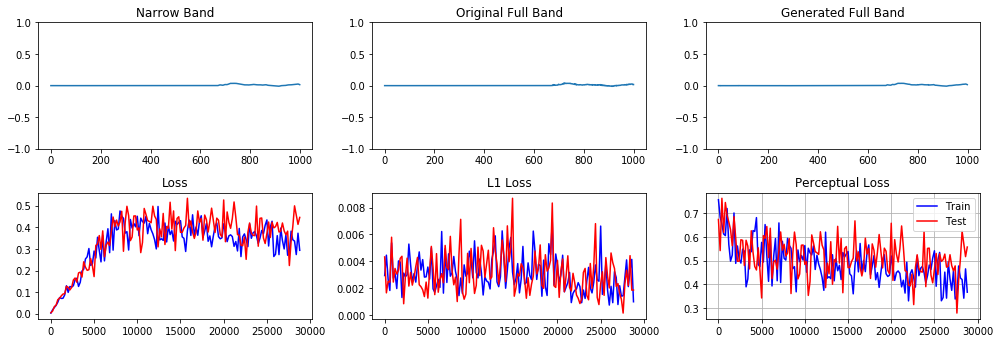

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

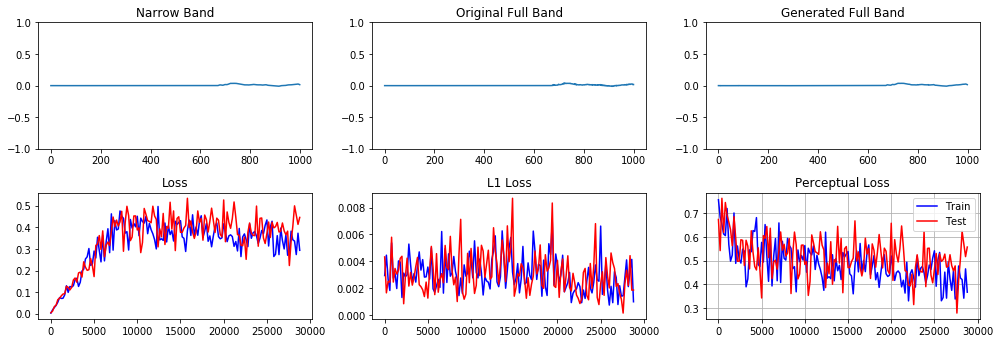

In [13]:
steps = []
losses, losses_t = [], []
l1_losses, l1_losses_t = [], []
p_losses, p_losses_t = [], []
step = 0
while step < 100000:
    x, y = data.get_batch_all()
    train_rate = 0.0001; 
    if step > 20000: 
        train_rate = 0.00001
    _, v_loss, v_loss1, v_loss2 = sess.run(
        [op, loss, loss1, loss2], feed_dict={X:x, Y:y, R: train_rate, C:min(step/10000, 0.8)})
    v_loss_flw = v_loss_flw * 0.95 + 0.05 * v_loss
    if step % 200 == 0:
        x, y = data_test.get_batch_all()
        v_output, v_loss_t, v_loss1_t, v_loss2_t = sess.run(
            [X_output, loss, loss1, loss2], feed_dict={X:x, Y:y, C:min(step/10000, 0.8)})
        
        steps.append(step)
        losses.append(v_loss); losses_t.append(v_loss_t)
        l1_losses.append(v_loss1); l1_losses_t.append(v_loss1_t)
        p_losses.append(v_loss2); p_losses_t.append(v_loss2_t)
        visualize(steps, losses, losses_t, l1_losses, l1_losses_t, p_losses, p_losses_t, x, y, v_output)
    if step % 10000 == 0 and step != 0:
        save(saver, sess, './' + exp_name, step)
    step = step + 1

### Testing

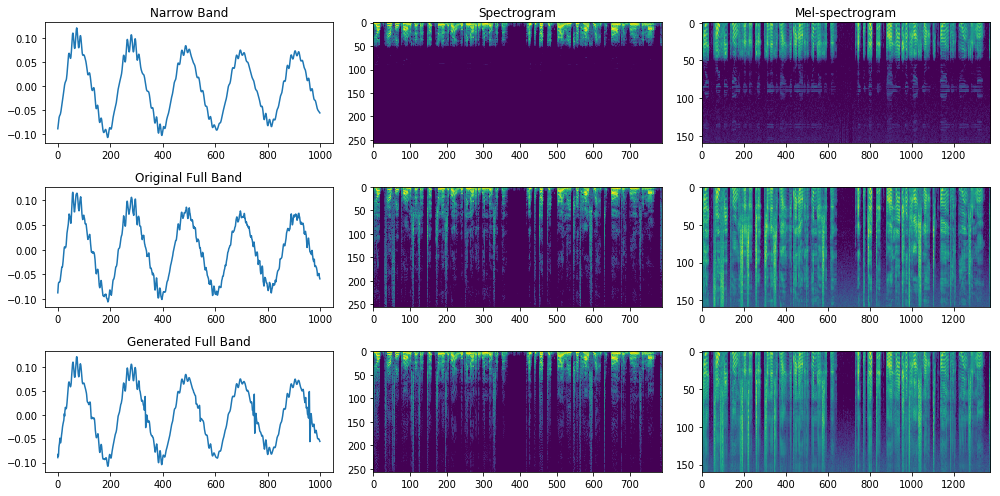

In [14]:
import librosa
import IPython.display as ipd
import scipy

x, y = data.get_all_test()

v_output, v_sx, v_sy, v_soutput = sess.run([X_output, X_spec, Y_spec, output_spec], feed_dict={X:x, Y:y})

_,_, spec_x = scipy.signal.spectrogram(x[0], nperseg=512)
_,_, spec_y = scipy.signal.spectrogram(y[0], nperseg=512)
_,_, spec_output = scipy.signal.spectrogram(v_output[0], nperseg=512)

plt.figure(figsize=[14,7])
plt.subplot(331); plt.plot(x[0, 0:1000]); plt.title('Narrow Band')
plt.subplot(334); plt.plot(y[0, 0:1000]); plt.title('Original Full Band')
plt.subplot(337); plt.plot(v_output[0, 0:1000]); plt.title('Generated Full Band')
plt.subplot(332); plt.imshow(np.maximum(-16,np.log(spec_x)), aspect='auto'); plt.title('Spectrogram')
plt.subplot(335); plt.imshow(np.maximum(-16,np.log(spec_y)), aspect='auto')
plt.subplot(338); plt.imshow(np.maximum(-16,np.log(spec_output)), aspect='auto')
plt.subplot(333); plt.imshow(v_sx[0].T, aspect='auto'); plt.title('Mel-spectrogram')
plt.subplot(336); plt.imshow(v_sy[0].T, aspect='auto')
plt.subplot(339); plt.imshow(v_soutput[0].T, aspect='auto')
plt.tight_layout()

ipd.display(ipd.Audio(x[0], rate=44100))
ipd.display(ipd.Audio(y[0], rate=44100))
ipd.display(ipd.Audio(v_output[0], rate=44100))